<div style="text-align: center; 
            background: linear-gradient(to right, #0f2027, #203a43, #2c5364); 
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; 
            color: #00ffcc; 
            padding: 25px; 
            line-height: 1.3; 
            border-radius: 12px; 
            border: 2px solid #00ffcc;
            box-shadow: 0 4px 12px rgba(0, 255, 204, 0.5); 
            letter-spacing: 1px;
            font-weight: bold;
            font-size: 28px;">
   SPORTS IMAGE CLASSIFICATION 
</div>


# Import Libraries

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

import os
import glob
import cv2

import tensorflow as tf
import keras
from keras.preprocessing import image
from keras import applications
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, MaxPooling2D, MaxPool2D,Dropout
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import RMSprop
from keras.applications.xception import Xception
from sklearn.metrics import classification_report

import warnings
warnings.simplefilter('ignore')

In [2]:
path = '/kaggle/input/sports-classification'

In [3]:
train_images_paths = glob.glob(path + '/train/*/*')
test_images_paths = glob.glob(path + '/train/*/*')

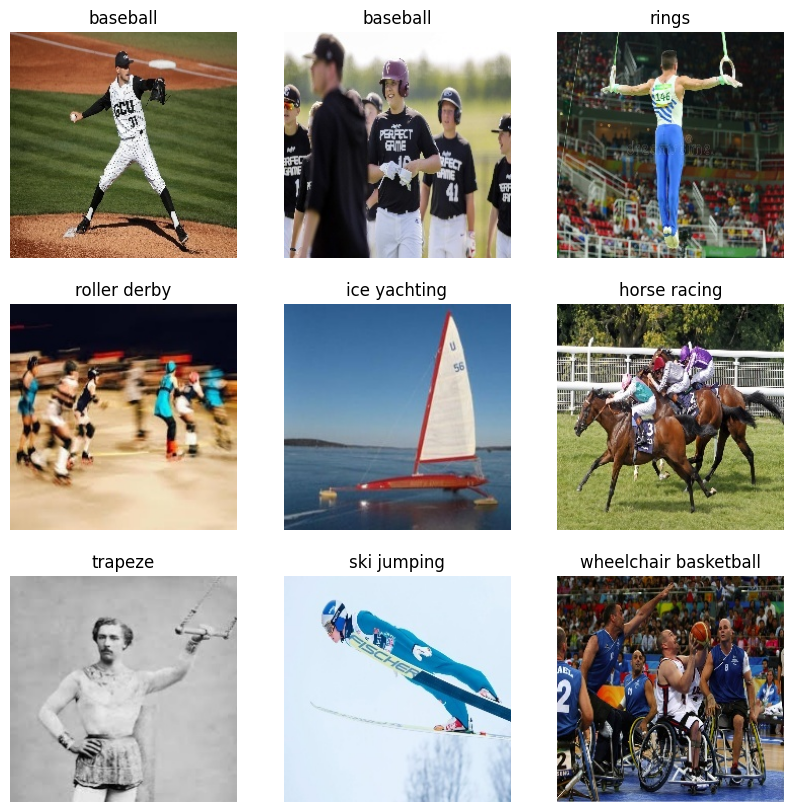

In [4]:
sample_image_paths = random.sample(train_images_paths, 9)

plt.figure(figsize=(10, 10))
for i, img_path in enumerate(sample_image_paths):
    img = cv2.imread(img_path)
    img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img1)
    plt.title(img_path.split('/')[-2])
    plt.axis('off')
plt.show()

In [5]:
train_labels = os.listdir(path + '/train/')

In [6]:
count_dict = {}
img_dict = {}

for cls in train_labels:
    image_path = glob.glob(f'{path}/train/{cls}/*')
    count_dict[cls] = len(image_path)

    if image_path:
        img_dict[cls] = tf.keras.utils.load_img(random.choice(image_path))
count_dict

df = pd.DataFrame(data={'label':count_dict.keys(),'count':count_dict.values()})
df

,label,count
0,bobsled,138
1,hurdles,136
2,snow boarding,117
3,fly fishing,134
4,luge,127
...,...,...
95,figure skating pairs,151
96,sailboat racing,144
97,sumo wrestling,133
98,arm wrestling,99


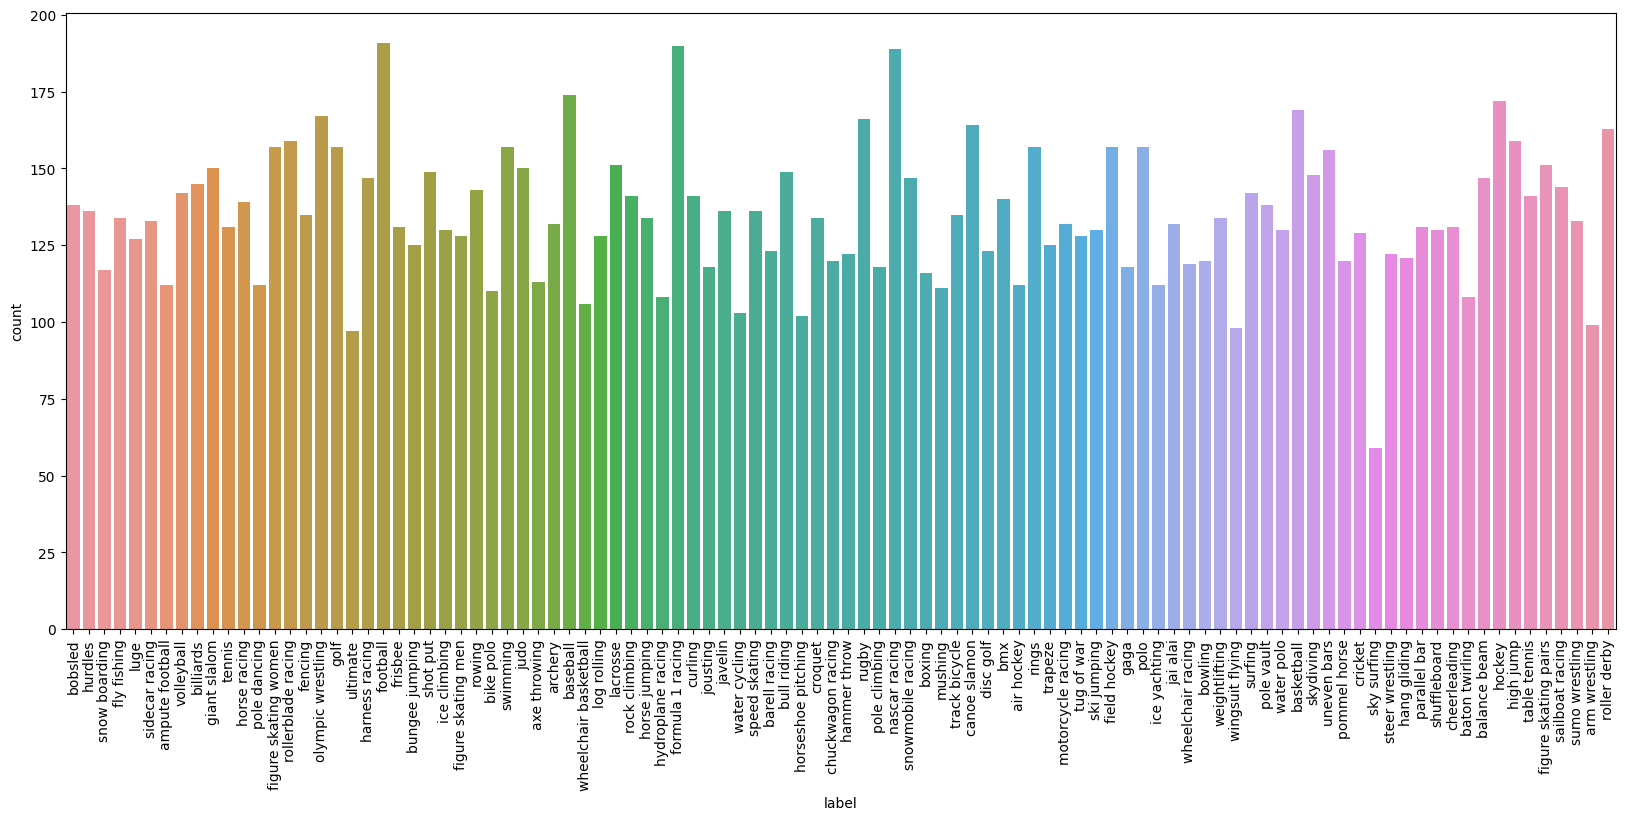

In [7]:
plt.figure(figsize=(20,8))
sns.barplot(x='label',y='count',data=df)
plt.xticks(rotation=90)
plt.show()

# Data Preprecessing

In [8]:
train_data = tf.keras.utils.image_dataset_from_directory(
    path + '/train',
    label_mode='categorical',
    shuffle=False
)
test_data = tf.keras.utils.image_dataset_from_directory(
    path + '/test',
    shuffle=False,
    label_mode='categorical'
)
validation_data = tf.keras.utils.image_dataset_from_directory(
    path + '/valid',
    label_mode='categorical',
    shuffle=False
)

Found 13492 files belonging to 100 classes.


I0000 00:00:1753331377.110470      85 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753331377.111205      85 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.


In [9]:
width = 224
height = 224
channels = 3

data_preprocessing = tf.keras.Sequential([
    tf.keras.layers.Resizing(height, width),
    tf.keras.layers.Rescaling(1.0 / 255),

])

In [10]:
train_ds = train_data.map(lambda x,y:(data_preprocessing(x),y))
test_ds = test_data.map(lambda x,y:(data_preprocessing(x),y))
valid_ds = validation_data.map(lambda x,y:(data_preprocessing(x),y))

# Data Augmentation¶

In [11]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [12]:
batch_size = 40

# augmentation for the training data
train_gen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
)

# only rescaling for the test data
test_gen = ImageDataGenerator()

In [13]:
train_generator = train_gen.flow_from_directory(
    path + '/train',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

test_generator = test_gen.flow_from_directory(
    path + '/test',
    class_mode="categorical",
    target_size=(224, 224),
    batch_size=batch_size,
    shuffle=False,
    seed=42
)


Found 13492 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


In [14]:
batch_images, batch_labels = next(train_generator)

print("Batch images shape:", batch_images.shape)
print("Batch labels shape:", batch_labels.shape)

Batch images shape: (40, 224, 224, 3)
Batch labels shape: (40, 100)


In [15]:
val_datagen = ImageDataGenerator()

validation_generator = val_datagen.flow_from_directory(
    path + '/valid',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = False,
    seed = 42
)

Found 500 images belonging to 100 classes.


# Xception Model

In [16]:
base_model_xception = Xception(weights='imagenet', include_top=False, input_shape=(224,224,3))

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
model_xception = Sequential([
    base_model_xception,
    GlobalAveragePooling2D(),
    Dropout(0.25),
    Dense(100, activation='softmax')
])

In [18]:
model_xception.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       204,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,066,380 (80.36 MB)

 Trainable params: 21,011,852 (80.15 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [19]:
model_xception.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

In [20]:
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

In [21]:
xception_history_ = model_xception.fit(
        train_generator,
        epochs=20,
        validation_data=validation_generator,
        callbacks = [early_stopping, reduce_lr])

Epoch 1/20


I0000 00:00:1753331422.634957     143 service.cc:148] XLA service 0x7ae904002680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753331422.636393     143 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753331422.636418     143 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753331425.893970     143 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1753331445.218449     143 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753331445.413519     143 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753331446.824424     143 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. Th

120/338 ━━━━━━━━━━━━━━━━━━━━ 2:59 825ms/step - accuracy: 0.2469 - loss: 3.3964

E0000 00:00:1753331565.737347     144 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753331565.885006     144 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753331566.394408     144 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753331566.530020     144 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


338/338 ━━━━━━━━━━━━━━━━━━━━ 384s 932ms/step - accuracy: 0.4085 - loss: 2.5008 - val_accuracy: 0.5540 - val_loss: 1.7622 - learning_rate: 0.0010
Epoch 2/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 194s 571ms/step - accuracy: 0.7683 - loss: 0.8073 - val_accuracy: 0.7620 - val_loss: 0.8652 - learning_rate: 0.0010
Epoch 3/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 194s 572ms/step - accuracy: 0.8303 - loss: 0.5812 - val_accuracy: 0.8320 - val_loss: 0.6131 - learning_rate: 0.0010
Epoch 4/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 193s 570ms/step - accuracy: 0.8507 - loss: 0.4908 - val_accuracy: 0.7520 - val_loss: 0.8877 - learning_rate: 0.0010
Epoch 5/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 193s 569ms/step - accuracy: 0.8759 - loss: 0.4110 - val_accuracy: 0.7860 - val_loss: 0.8120 - learning_rate: 0.0010
Epoch 6/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.8978 - loss: 0.3306
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
338/338 ━━━━━━━━━━━━━━━━━━━━ 193s 569ms/step - accuracy: 0.8978 - 

# Model Evaluation

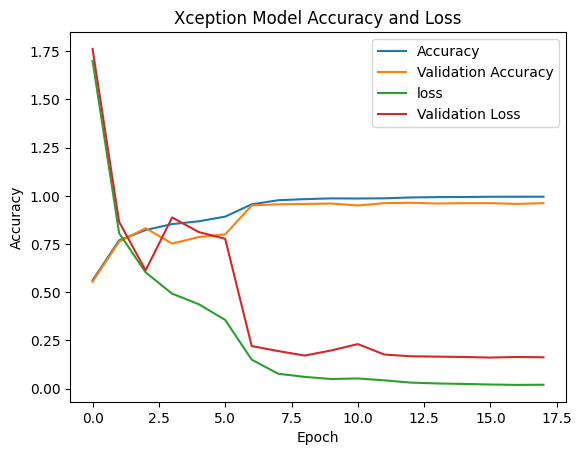

In [22]:
plt.plot(xception_history_.history["accuracy"])
plt.plot(xception_history_.history['val_accuracy'])
plt.plot(xception_history_.history['loss'])
plt.plot(xception_history_.history['val_loss'])
plt.title("Xception Model Accuracy and Loss")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [24]:
# Predict probabilities for the test set
y_pred_probs = model_xception.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Get the class names
class_names = list(test_generator.class_indices.keys())

# Generate and print the classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("\nClassification Report:")
print(report)

13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 642ms/step

Classification Report:
                       precision    recall  f1-score   support

           air hockey       1.00      1.00      1.00         5
      ampute football       1.00      1.00      1.00         5
              archery       1.00      1.00      1.00         5
        arm wrestling       1.00      1.00      1.00         5
         axe throwing       0.83      1.00      0.91         5
         balance beam       1.00      1.00      1.00         5
        barell racing       1.00      1.00      1.00         5
             baseball       1.00      1.00      1.00         5
           basketball       0.83      1.00      0.91         5
       baton twirling       1.00      1.00      1.00         5
            bike polo       1.00      1.00      1.00         5
            billiards       1.00      1.00      1.00         5
                  bmx       1.00      0.80      0.89         5
              bobsled       1.00      0.80      0.8

# Save Model

In [25]:
model_xception.save('/kaggle/working/model_xception.h5')

In [26]:
import json

labels_dict = train_generator.class_indices

index_to_class = {v: k for k, v in labels_dict.items()}

with open('/kaggle/working/labels.json', 'w') as f:
    json.dump(index_to_class, f)
